<center><img src="https://ingenieria2.udea.edu.co/gepp/assets/logo-ingenieria-udea.svg"></center>


# PROYECTO FINAL


**Tratamiento de Señales III**

*Presentado por:*

*Luis alberto Ochoa M.*

*Jhon James Tapie P.*

*Prof. Hernán Felipe García Arias.*

**Facultad de Ingeniería**

**Universidad de Antioquia**

2023-1

# **Demodulador 16QAM**

## Objetivo:

Implementación de un Demodulador 16QAM mediante modelos de clasificación de aprendizaje supervisado para recuperar los bits transmitidos en un canal AWGN.

## Presentación del problema

El uso de la inteligencia artificial en los receptores de radio es una tendencia emergente que busca mejorar las prestaciones en las comunicaciones móviles. En particular, en la quinta generación de comunicaciones móviles se está aprovechando la inteligencia artificial para optimizar la gestión de recursos a nivel de red y capa física.

La integración de la inteligencia artificial en estos sistemas permite desarrollar algoritmos de detección y decodificación más avanzados y eficientes. Estos algoritmos son capaces de adaptarse a las condiciones cambiantes del canal de comunicación, incrementar la tolerancia a errores y maximizar la tasa de transmisión de datos.

Por lo tanto, el objetivo de este trabajo es implementar un demodulador 16QAM que permita recuperar los bits transmitidos a través de un canal AWGN. Los datos recuperados desde el receptor se presentan en forma compleja, en las componentes fase y cuadratura (I/Q), conformando así un dataset para su posterior análisis y procesamiento.

Con esta implementación, se busca aprovechar las capacidades de la inteligencia artificial para mejorar la calidad y eficiencia de la comunicación inalámbrica, permitiendo una mejor recuperación de los datos transmitidos en condiciones de baja relación Señal a Ruido (SNR).

# Librerías

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
import ipywidgets as widgets
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.optimizers import Adam, SGD, Nadam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error

## Dataset
El Dataset se conforma por un archivo .csv que contiene las características de entrada para entrenar el modelo de IA. Los datos de
entrenamiento están en el archivo “Dataset_16QAM.csv”. Los datos se generaron con una relación de señal a ruido SNR de
[-10,-5,0,5,10,15,20]dB. 

Adicionalmente, se dispone de un conjunto de datos de prueba con características similares al conjunto de datos de entrenamiento, pero con menos datos. Este conjunto se utilizará para evaluar el modelo y determinar su rendimiento al introducir datos completamente nuevos.

In [49]:
!wget "https://raw.githubusercontent.com/LuisOchoaM/Proyecto_Final_TS3/main/Dataset_16QAM.csv" -O "df.csv"
!wget "https://raw.githubusercontent.com/LuisOchoaM/Proyecto_Final_TS3/main/Dataset_16QAM_test.csv" -O "df_test.csv"

--2023-06-09 18:41:07--  https://raw.githubusercontent.com/LuisOchoaM/Proyecto_Final_TS3/main/Dataset_16QAM.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 609574 (595K) [text/plain]
Saving to: ‘df.csv’

df.csv              100%[===================>] 595.29K  --.-KB/s    in 0.04s   

2023-06-09 18:41:07 (13.6 MB/s) - ‘df.csv’ saved [609574/609574]

--2023-06-09 18:41:07--  https://raw.githubusercontent.com/LuisOchoaM/Proyecto_Final_TS3/main/Dataset_16QAM_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307156 (300K) [t

### Lectura de los datos de entrenamiento y de evaluación
Debido a que no se pudo realizar la lectura correcta de los datasets descargados desde el repositorio de GitHub, se decidió optar por acceder a ellos a través de Google Drive como alternativa.

In [50]:
df_test = pd.read_csv('df_test.csv')
url_training = 'https://drive.google.com/uc?id=1fXHJVAI4cijBs97gvPVnddsORWBCwSAQ'
signal = pd.read_csv(url_training,sep=';',index_col=0)
df = pd.DataFrame(signal)

### Dataset para entrenar el modelo

In [51]:
df

,Real,Imaginario,Map
SNR,,,
-10,-0.321734,2.256881,13
-10,-3.721091,1.576841,1
-10,-1.257743,-0.210152,1
-10,-6.917534,4.011253,3
-10,0.842395,4.023504,14
...,...,...,...
20,-0.881438,-1.112599,5
20,0.997506,1.155871,15
20,-2.919098,-0.848539,1


### Dataset para evaluar el modelo.

In [52]:
df_test

,SNR,Parte Real,Parte Imaginaria,Mapeo
0,-10,-3.976007,-0.466537,0
1,-10,-2.169444,-2.815817,1
2,-10,-9.645901,0.862017,2
3,-10,-12.155269,2.188394,3
4,-10,8.045482,-0.809773,4
...,...,...,...,...
7051,20,2.744817,0.855834,11
7052,20,0.951973,-2.796716,12
7053,20,0.969584,-0.953403,13
7054,20,0.777557,2.888277,14


# **Preprocesamiento**

Se extraen los datos (I/Q) y las etiquetas (Mapeo)

In [53]:
x = df.iloc[:, :2]
y = df.iloc[:, 2]

### Se tienen 2000 datos por cada valor de SNR

In [54]:
valores_snr = df.index.unique()
print(valores_snr)
df.index.value_counts()

Int64Index([-10, -5, 0, 5, 10, 15, 20], dtype='int64', name='SNR')


-10    2000
-5     2000
 0     2000
 5     2000
 10    2000
 15    2000
 20    2000
Name: SNR, dtype: int64

### Escalado de datos
Se realizó el escalado de los datos utilizando diferentes escaladores con el objetivo de determinar, junto con los demás parámetros y configuraciones del modelo, con qué tipo de escalado se obtienen mejores resultados.

In [55]:
escaladores = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'MaxAbsScaler': MaxAbsScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer': Normalizer(),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal'),
    'PowerTransformer': PowerTransformer()
}

In [56]:
dropdown_escalador = widgets.Dropdown(options=list(escaladores.keys()), description='Escalador:')

def actualizar_grafica(escalador):
  scaler = escaladores[escalador]
  datos_normalizados = scaler.fit_transform(x)

  df_normalizado = pd.DataFrame(datos_normalizados, index=df.index, columns=['Real', 'Imaginario'])
  df_normalizado['Map'] = df['Map']
  #print(df_normalizado)

  fig, axs = plt.subplots(len(valores_snr), 1, figsize=(6, len(valores_snr) * 4), sharex=True)
  for i, snr in enumerate(valores_snr):
      datos_snr = df_normalizado.loc[snr]
      ax = axs[i]
      
      ax.scatter(datos_snr['Real'], datos_snr['Imaginario'], c=datos_snr['Map'],  cmap='viridis')
      ax.set_title('SNR = {}'.format(snr))
      ax.set_xlabel('Real')
      ax.set_ylabel('Imaginario')
      #ax.set_xlim(-5,5)
      #ax.set_ylim(-5,5)

  # Ajustar los espacios entre subgráficas
  plt.tight_layout()

  # Mostrar la gráfica
  plt.show()

widgets.interactive(actualizar_grafica, escalador=dropdown_escalador)

interactive(children=(Dropdown(description='Escalador:', options=('StandardScaler', 'MinMaxScaler', 'MaxAbsSca…

### Se  escalan los datos 
Según las pruebas realizadas, se observó que el uso del StandardScaler() proporciona los mejores resultados.

In [57]:
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

#### Se realiza la técnica de codificación one-hot encoding para convertir las etiquetas a una representación binaria.

In [58]:
encoder = OneHotEncoder(sparse_output=False)
y_new = encoder.fit_transform(y.to_numpy().reshape(-1, 1))

# **Modelo de clasificación multiclase MLP**

Se dividen los datos en 80% para entrenar y 20% para evaluar el modelo.

In [59]:
# Split the data for training and testing
train_x, test_x, train_y, test_y = train_test_split(x_norm, y_new, test_size=0.20,random_state=147)

In [60]:
# Build the model

tasa_aprendizaje= 0.001
tamaño_lote = 48

model = Sequential()
model.add(Dense(64, input_shape=(2,), activation='relu', name='Layer1'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', name='Layer2'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', name='Layer3'))
model.add(Dense(16, activation='softmax', name='output'))

# Adding L2 regularization to the Dense layers
regularization = regularizers.l2(0.02) # regularización más alta generaliza más a datos nuevos.
for layer in model.layers:
    if isinstance(layer, Dense):
        layer.kernel_regularizer = regularization

optimizer = Adam(learning_rate=tasa_aprendizaje)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print('Neural Network Model Summary: ')
print(model.summary())

# Train the model


# Evaluate the model
loss, accuracy = model.evaluate(test_x, test_y)
checkpoint_path = 'mejor_modelo.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

reporte = model.fit(train_x, train_y,validation_data=(test_x,test_y), callbacks=[checkpoint], verbose=2, batch_size=tamaño_lote, epochs=300, shuffle=True)

model.load_weights(checkpoint_path)
print('Final test set loss: {:4f}'.format(loss))
print('Final test set accuracy: {:4f}'.format(accuracy))

Neural Network Model Summary: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Dense)              (None, 64)                192       
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 Layer2 (Dense)              (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 Layer3 (Dense)              (None, 32)                2080      
                                                                 
 output (Dense)              (None, 16)                528       
                                                                 
Total params: 6,960
Tra

In [61]:
results = model.evaluate(test_x, test_y)
print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

88/88 [==============================] - 0s 2ms/step - loss: 1.2195 - accuracy: 0.6729
Final test set loss: 1.219461
Final test set accuracy: 0.672857


accu  [0.3598214387893677, 0.5491964221000671, 0.5897321701049805, 0.6083035469055176, 0.6188392639160156, 0.6225000023841858, 0.6284821629524231, 0.6345535516738892, 0.6358035802841187, 0.6337500214576721, 0.6413393020629883, 0.6371428370475769, 0.6423214077949524, 0.6395535469055176, 0.6441964507102966, 0.6458035707473755, 0.6472321152687073, 0.6461607217788696, 0.6458035707473755, 0.6483928561210632, 0.6433928608894348, 0.6482142806053162, 0.6464285850524902, 0.6501785516738892, 0.6505357027053833, 0.6502678394317627, 0.6534821391105652, 0.6469643115997314, 0.6514285802841187, 0.6514285802841187, 0.6496428847312927, 0.6512500047683716, 0.6492857336997986, 0.6493750214576721, 0.6499999761581421, 0.6513392925262451, 0.6517857313156128, 0.6510714292526245, 0.6521428823471069, 0.6513392925262451, 0.6540178656578064, 0.6504464149475098, 0.6528571248054504, 0.6571428775787354, 0.6513392925262451, 0.6503571271896362, 0.6472321152687073, 0.651160717010498, 0.6533035635948181, 0.652767837047

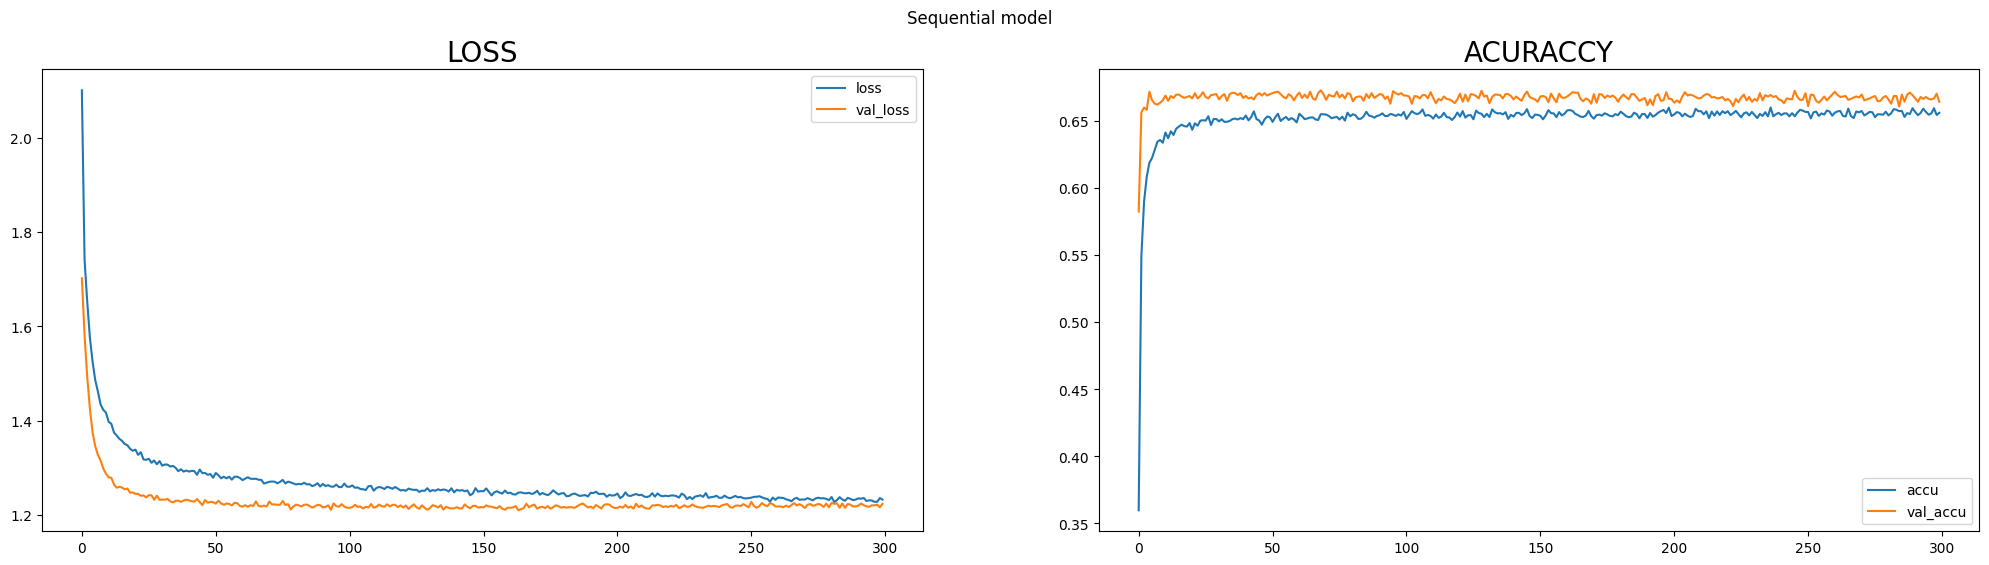

In [62]:
val_loss = reporte.history['loss']
val_accu = reporte.history['accuracy']

val_val_loss = reporte.history['val_loss']
val_val_accu = reporte.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,6))
fig.suptitle('Sequential model')
ax1.plot(val_loss,label='loss')
ax1.plot(val_val_loss,label='val_loss')
ax1.set_title('LOSS',fontsize=20)
ax1.legend()
ax2.plot(val_accu,label='accu')
ax2.plot(val_val_accu,label='val_accu')
ax2.set_title('ACURACCY',fontsize=20)
ax2.legend()

print('accu ',val_accu )
print('val_accu ',val_val_accu)


- En la gráfica de perdidas (Loss), se observa que las pérdidas de entrenamiento y validación convergen muy rápido y siguen disminuyendo a medida que avanza el entrenamiento, lo que indica que el modelo está aprendiendo y mejorando su rendimiento. Aunque la pérdida de entrenamiento es inicialmente mayor que la de validación, esta empieza a disminuir a medida que el modelo se ajusta a los datos. Sin embargo, la pérdida de validación comienza a fluctuar o aumentar ligeramente, a partir de la época 100, lo que denota que empieza a haber un sobreentrenamiento en el modelo, y por ende, es posible que el modelo no generalice bien para nuevos datos.

- Algo similar, se puede observar en la gráfica de Accuracy. Donde, La accuracy en los datos de entrenamiento muestra una tendencia ascendente desde alrededor de 0.44 hasta aproximadamente 0.66, con fluctuaciones entre 0.65 y 0.66 después. De manera similar, la accuracy en los datos de validación aumenta inicialmente de 0.63 a aproximadamente 0.67 y luego fluctúa. Estos resultados indican que el modelo mejora su rendimiento a medida que se va entrenando. Además, al obtener un mejor accuracy en los datos de validación, indica una buena capacidad de clasificación del modelo en datos nuevos y no vistos durante el entrenamiento. Sin embargo, el modelo converge muy rápido y no presenta una mejora significativa. Por otro lado, a medida que aumenta el número de épocas, el accuracy de validación empieza a disminuir con respecto al de entrenamiento, indicando también un sobreentrenamiento.

- Por lo tanto, incrementar aún más el número de épocas en el clasificar no presenta mayor beneficio tanto en las perdidas como en el accuracy.



### Matriz de Confusión

88/88 [==============================] - 0s 1ms/step


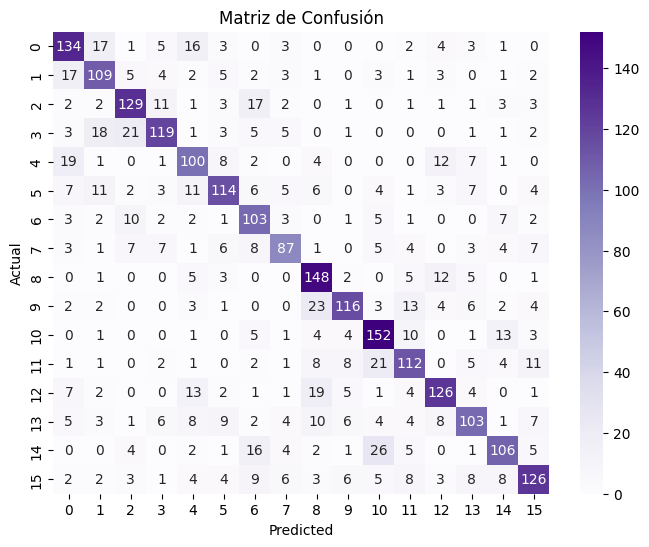

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Probabilidades de predicción
probabilidades_prediccion = model.predict(test_x) # Clasificaciones del modelo

# Obtener las predicciones del modelo
pred_y = probabilidades_prediccion

# Obtener la matriz de confusión
cm = confusion_matrix(np.argmax(test_y, axis=1), np.argmax(pred_y, axis=1))

plt.figure(figsize=(8, 6))

# Visualizar la matriz de confusión utilizando Seaborn y Matplotlib
sns.heatmap(cm, annot=True, cmap='Purples', fmt='d', xticklabels=np.unique(np.argmax(test_y, axis=1)), yticklabels=np.unique(np.argmax(test_y, axis=1)))

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

### ROC (Receiver Operating Characteristic)
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

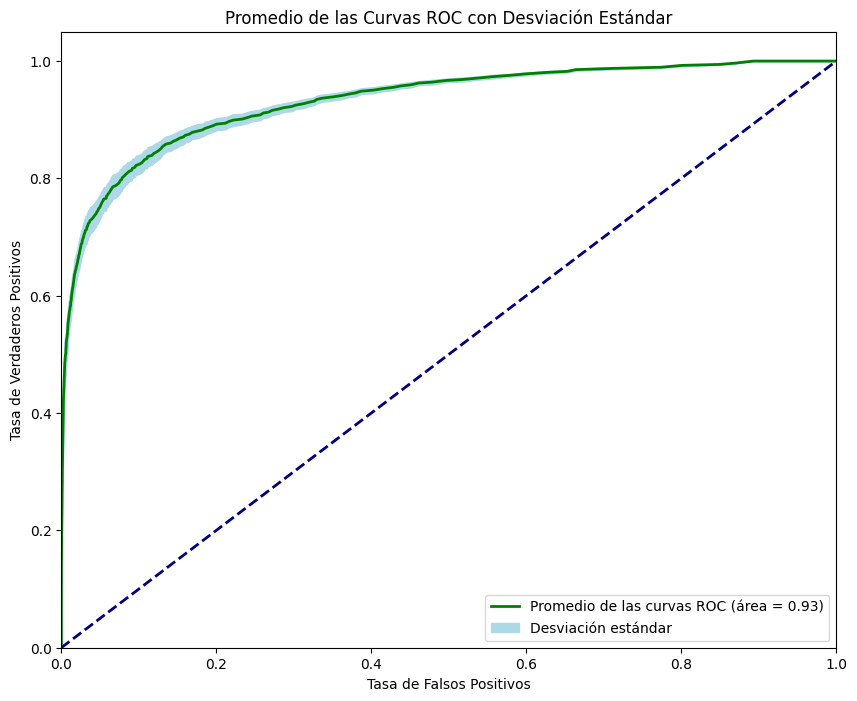

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Binarizar las etiquetas para cada clase
binarizer = LabelBinarizer()
binarized_labels = binarizer.fit_transform(test_y)

# Calcular la curva ROC y el área ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(binarized_labels.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], probabilidades_prediccion[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Encontrar la longitud máxima de las curvas ROC
max_length = max([len(fpr[i]) for i in range(binarized_labels.shape[1])])

# Rellenar las curvas más cortas con la interpolación del promedio de la clase
for i in range(binarized_labels.shape[1]):
    if len(fpr[i]) < max_length:
        x = np.linspace(0, 1, num=len(fpr[i]))
        x_interp = np.linspace(0, 1, num=max_length)
        fpr[i] = np.interp(x_interp, x, fpr[i])
        tpr[i] = np.interp(x_interp, x, tpr[i])

# Calcular el promedio y la desviación estándar de las curvas ROC
mean_fpr = np.mean([fpr[i] for i in range(binarized_labels.shape[1])], axis=0)
mean_tpr = np.mean([tpr[i] for i in range(binarized_labels.shape[1])], axis=0)
std_fpr = np.std([fpr[i] for i in range(binarized_labels.shape[1])], axis=0)
std_tpr = np.std([tpr[i] for i in range(binarized_labels.shape[1])], axis=0)
mean_roc_auc = np.mean(list(roc_auc.values()), axis=0)

# Graficar el promedio de las curvas ROC con desviación estándar
plt.figure(figsize=(10, 8))
plt.plot(mean_fpr, mean_tpr, color='green', lw=2, label='Promedio de las curvas ROC (área = {})'.format(np.round(mean_roc_auc, 2)))
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='lightblue', alpha=1, label='Desviación estándar')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Promedio de las Curvas ROC con Desviación Estándar')
plt.legend(loc='lower right')
plt.show()

### Observaciones

La curva ROC muestra cómo varía la capacidad del clasificador para detectar verdaderos positivos a medida que también aumenta la tasa de falsos positivos. 

- Basandonos en la gráfica, se observa que la Tasa de Verdaderos Positivos (TPR) aumenta rápidamente para pequeñas Tasas de Falsos Positivos (FPR) y sigue aumentando progresivamente, lo que indica que el modelo está siendo más efectivo en la detección de los símbolos positivos y mejora su rendimiento a medida que avanza. De igual manera, indica que el modelo comete algunos errores al clasificar los símbolos negativos, pero en general mantiene un nivel relativamente bajo de falsos positivos, teniendo así un comportamiento muy bueno.

- Además, lo anterior se puede confirmar, observando el valor del área bajo la curva (ROC), que en este caso ROC = 0.93, lo cual refleja también, que el modelo tiene un buen rendimiento en términos de clasificación y capacidad de discriminación entre los simbolos.

- Por otro lado, cabe resaltar que a pesar de que la curva ROC es buena, la matriz de confusión de manera más detallada muestra que hay clases donde se equivoca gran cantidad de veces, indicando dificultades para distinguirlas. Además, se observa una mayor confusión en ciertas clases en comparación con otras, es decir, que hay un rendimiento desigual en la precisión de clasificación. Lo anterior pude suceder debido a las diferentes SNRs que se tienen en el conjunto de datos, especialmente en SNRs muy bajitas y que no son proporcionales en todos las clases (símbolos) , lo cual afecta en el entrenamiento del modelo y posteriormente en la clasificación (evaluación).

### Evaluación del modelo con un Daset nuevo.

Ahora, con el propósito de seguir evaluando el modelo entrenado. Vamos a clasificar las etiquetas con el dataset nuevo y calculamos el porcentaje de acierto, comparando las etiquetas clasificadas por el modelo con las etiquetas verdaderas. 

 

In [65]:
prueba = pd.read_csv('https://drive.google.com/uc?id=1UXIp0elFRHH1Ex4kpj9V426piA3nolgK',sep=',',  index_col=False)
prueba = prueba.reset_index(drop=True)
df_validation = pd.DataFrame(prueba)

x_validation = df_validation.iloc[:, 1:3]
x_validation

y_validation = df_validation.iloc[:,3]

In [66]:
scaler = StandardScaler()
x_validation_norm_ = scaler.fit_transform(x_validation)

In [67]:
# Realizar la predicción de las etiquetas con los datos de validación
pred_y = model.predict(x_validation_norm_)

# Convertir las predicciones a índices de clase
pred_y_num = np.argmax(pred_y, axis=1)

# Contar los aciertos
aciertos = np.sum(pred_y_num == y_validation)

# Calcular el porcentaje de acierto
porcentaje = (aciertos / len(pred_y_num)) * 100
print("Porcentaje de acierto (%):", porcentaje)

221/221 [==============================] - 0s 2ms/step
Porcentaje de acierto (%): 49.107142857142854


Como se puede observar, se obtuvo un porcentaje de acierto del 51.1%. Por ende, su desempeño no es muy bueno. En este caso, el modelo está clasificando correctamente aproximadamente la mitad de los símbolos, lo que implica que tiene dificultades para clasificar conjuntos de datos totalmente nuevos que no ha visto durante el entrenamiento

### **Modelo de clasificación multiclase SVM** 


A continuación se realiza una clasificación de las 16 simbolos utilizando una SVM o máquina de soporte vectorial. Este modelo funciona correlacionando datos a un espacio de características de grandes dimensiones de forma que los puntos de datos se puedan categorizar, incluso si los datos no se puedan separar linealmente de otro modo.


Se dividen los datos en 80% para entrenar y 20% para evaluar el modelo.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Split the data for training and testing
train_x_, test_x_, train_y_, test_y_ = train_test_split(x_norm, y_new, test_size=0.20,random_state=147)
t_train = np.argmax(train_y_, axis = 1) #Etiqutas de entrenamiento
t_test = np.argmax(test_y_, axis = 1)   #Etiquetas de prueba

#### Visualización de los datos de prueba

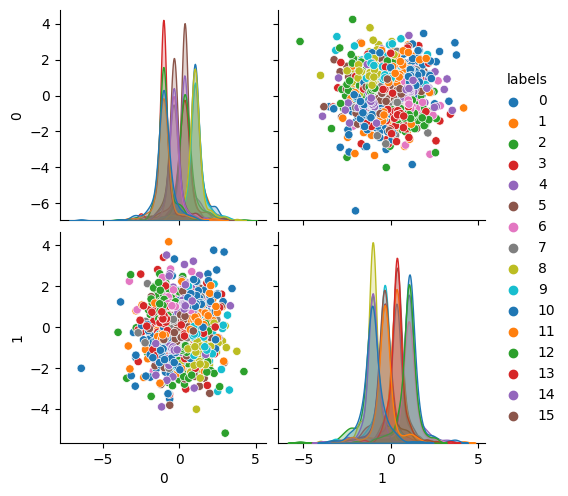

In [23]:
import seaborn as sns
dataFrame= pd.DataFrame(test_x_)
dataFrame['labels'] = t_test  #Etiquetas
sns.pairplot(dataFrame, hue='labels', palette= 'tab10')

### Se entrena y se busca los mejores parametros del modelo

In [24]:
# defining parameter range
param_grid = {'C': [0.1,10,100, 1000], #10,100, 1000]
              'gamma': [0.5, 0.1, 0.01, 0.001],#0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(train_x_, t_train)

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.653 total time=   3.3s
[CV 2/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.687 total time=   3.0s
[CV 3/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.653 total time=   3.0s
[CV 4/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.654 total time=   4.4s
[CV 5/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.672 total time=   3.8s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.650 total time=   3.7s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.683 total time=  10.7s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.654 total time=   6.6s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.652 total time=   4.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.671 total time=   5.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.401 total time=   5.6s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;

### Se evalua el desempeño del modelo con los mejores parametros obtenidos.

In [25]:
from sklearn.metrics import accuracy_score
# Hacer predicciones en datos de prueba
predictions = grid.best_estimator_.predict(test_x_)

# Evaluar el rendimiento del modelo en datos de prueba
accuracy = accuracy_score(t_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.6689285714285714


#### Matriz de Confusión

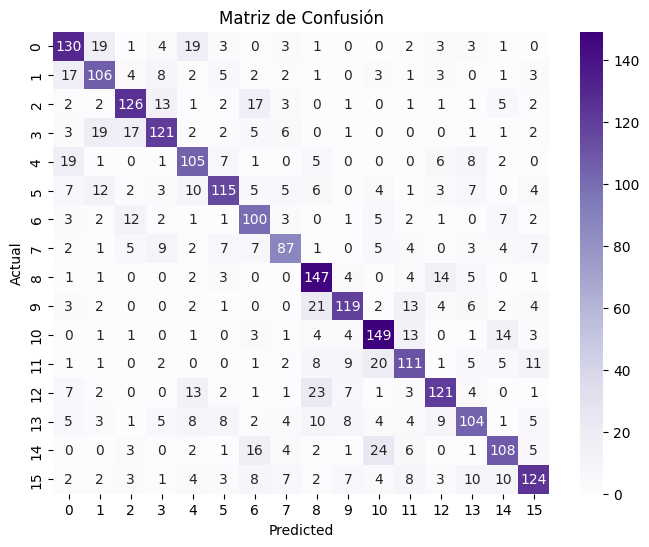

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
cm = confusion_matrix(t_test, predictions)

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 6))

# Visualizar la matriz de confusión utilizando Matplotlib
sns.heatmap(cm, annot=True, cmap='Purples', fmt='d', xticklabels=np.unique(t_test), yticklabels=np.unique(t_test))

# Ajustar las etiquetas de los ejes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')

# Mostrar la matriz de confusión
plt.show()

### Calculamos el porcentaje de acierto con el conjunto de datos nuevos.

In [27]:
# Realizar la clasificación de las etiquetas con los datos de validación
pred_y_svm = grid.best_estimator_.predict(x_validation_norm_)

# Contar los aciertos
aciertos = np.sum(pred_y_svm == y_validation)

# Calcular el porcentaje de acierto
porcentaje = (aciertos / len(pred_y_svm)) * 100
print("Porcentaje de acierto (%):", porcentaje)

Porcentaje de acierto (%): 48.96541950113379


### Observaciones

- En el modelo implementado, se probaron 16 combinaciones de hiperparámetros usando validación cruzada con 5 folds y kernel rbf en todos los casos. Se observó que las combinaciones con el score más alto y mostraron un mejor rendimiento del modelo fueron C=0.1, gamma=0.5, por otra parte, con un el mismo valor de regularización (C=0.1) y valores de gamma más pequeños (0.1 y 0.001, respectivamente), se obtuvieron puntajes significativamente bajos, lo que indica, que no son adecuados para el conjunto de datos y el modelo utilizado. Además, el tiempo total de ejecución para ajustar los modelos fue relativamente bueno, aproximadamente 8 minutos.

- Adicionalmente, probamos utilizar el modelo SVM con kernel PCA para transformar los datos y obtener una mejor separación entre los símbolos. Sin embargo, los resultados no fueron buenos, y la clasificación empeoró en comparación con los resultados obtenidos sin aplicar kernel PCA a los datos. Por lo tanto, decidimos no incluir el kernel PCA en el preprocesamiento de los datos.

- En general, en el caso del clasificador SVM, los resultados son muy aparecidos a los obtenidos con el clasificador MLP, tanto en el accuracy como en la matriz de confusión. Sin embargo, no se obtuvo una mejora en la clasificación, con un accuracy 67% en los datos de prueba y un porcentaje de acierto del 49% con el dataset nuevo , es decir, aproximadamente los mismos resultados obtenidos en el clasificador MLP. Algo que si se notó, y vale la pena destacar, es que el SVM es un algoritmo más óptimo en cuanto a tiempo de ejecución, ya que, se requirió menos tiempo de ejecución cuando se entrenó el modelo solo con los mejores  parámetros (C=0.1, gamma=0.5).

A continuación se muestra una tabla resumen con los desempeños obtenidos:

| Conjunto de datos| MLP | SVM | 
| ------ | ---- | ------ |
| Con el 20% de los datos   | 67.3%   | 66.9% |
|Con el daset nuevo | 49.1%   | 48.96% |


### Conclusiones

- El algoritmo de clasificación que mejor beneficio muestra tanto en accuracy como en porcentaje de acierto es el MLP, aunque por muy poco con respecto al SVM. En el caso de la SVM y el MLP puede que otra configuración de parámetros arroje mejores resultados, pero probarlo es bastante dispendioso dado la dificultad de probar tantos hiperparámetros por el tiempo de ejecución.

- Por otro lado, como se pudo observar, los modelos aplicados no lograron alcanzar valores de precisión y porcentajes de acierto muy altos, donde el valor más alto de accuracy obtenido fue del 67%. Sin embargo, esto era algo esperado debido a las características del conjunto de datos. Ya que, existe una notable variabilidad entre los diferentes valores de Relación Señal a Ruido (SNR) presentes en el dataset, lo que dificulta que el modelo tenga un buen desempeño en bajas SNR, debido a alto error en los símbolos introducido por el ruido.

- Adicionalmente, se obtuvo un porcentaje de acierto aproximadamente del 49%. En este caso, el modelo está clasificando correctamente menos de la mitad de las muestras, lo que implica que tiene dificultades para realizar clasificaciones precisas en el nuevo dataset. Por lo tanto, se debe buscar formas de mejorar el modelo, como ajustar los parámetros, aumentar el tamaño del conjunto de entrenamiento o considerar la utilización de otros algoritmos o técnicas de aprendizaje automático que puedan brindar mejores resultados.

- Por último, se destaca la importancia de continuar avanzando en el desarrollo y aplicación de estos modelos en la capa física de sistemas de radio. Dado que, podrían mejorar y optimizar los procesos en el ámbito de las comunicaciones inalámbricas y asegurar una comunicación confiable y eficiente, permitiendo así, superar los desafíos de baja Relación Señal a Ruido (SNR) y otros factores que puedan afectar la calidad de la señal. 